In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import scipy
from skimage import io
from skimage import img_as_float

In [2]:
def display_data(X):
    # Compute rows, cols
    m, n = X.shape
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)

    # Compute number of items to display
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = -np.ones((pad + display_rows * (example_height + pad),
                             pad + display_cols * (example_width + pad)))
    
    # Copy each example into a patch on the display array
    curr_ex = 0

    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            
            # Copy the patch
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex]))

            display_array[pad + j * (example_height + pad) + np.arange(example_height),
                          pad + i * (example_width + pad) + np.arange(example_width)[:, np.newaxis]] = \
                          X[curr_ex].reshape((example_height, example_width)) / max_val
            curr_ex += 1

        if curr_ex >= m:
            break
    
    # Display Image
    plt.imshow(display_array, cmap='gray', extent=([-1, 1, -1, 1]))
    plt.axis('off')

In [3]:
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [4]:
def compute_centroids(X, idx, K):
    # Useful variables
    m, n = X.shape

    # You need to return the following variables correctly.
    centroids = np.zeros((K, n))

    # ===================== Your Code Here =====================
    # Instructions: Go over every centroid and compute mean of all points that
    #               belong to it. Concretely, the row vector centroids[i]
    #               should contain the mean of the data points assigned to
    #               centroid i.
    #

    for k in range(K):
        X_k = X[np.where(idx == k)]
        centroid_k = np.sum(X_k, axis=0) / X_k.shape[0]
        centroids[k] = centroid_k

    # ==========================================================

    return centroids

In [5]:
def find_closest_centroids(X, centroids):
    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly.

    idx = np.zeros(X.shape[0])

    # ===================== Your Code Here =====================
    # Instructions : Go over every example, find its closest centroid, and store
    #                the index inside idx at the appropriate location.
    #                Concretely, idx[i] should contain the index of the centroid
    #                closest to example i. Hence, it should be a value in the
    #                range 0..k
    #

    m = X.shape[0]
    distance_matrix = np.zeros((m, K))

    for i in range(m):
        distance = X[i] - centroids # 1 * n
        distance_matrix[i] = np.sum(distance ** 2, axis=1) / m
    
    idx = np.argmin(distance_matrix, axis=1)

    # ==========================================================

    return idx

In [6]:
def kmeans_init_centroids(X, K):
    # You should return this value correctly
    centroids = np.zeros((K, X.shape[1]))

    # ===================== Your Code Here =====================
    # Instructions: You should set centroids to randomly chosen examples from
    #               the dataset X
    #

    X_shuffle = np.random.permutation(X.shape[0])
    centroids = X[X_shuffle[:K]]

    # ==========================================================

    return centroids

In [7]:
def project_data(X, U, K):
    # You need to return the following variables correctly.
    Z = np.zeros((X.shape[0], K))

    # ===================== Your Code Here =====================
    # Instructions: Compute the projection of the data using only the top K
    #               eigenvectors in U (first K columns).
    #               For the i-th example X[i], the projection on to the k-th
    #               eigenvector is given as follows:
    #                   x = X(i, :)';
    #                   projection_k = x' * U(:, k);
    #                   (above is octave code)
    #

    U_reduce = U[:, :K]
    Z = np.dot(X, U_reduce)

    # ==========================================================

    return Z

In [8]:
def recover_data(Z, U, K):
    # You need to return the following variables correctly.
    X_rec = np.zeros((Z.shape[0], U.shape[0]))

    # ===================== Your Code Here =====================
    # Instructions: Compute the approximation of the data by projecting back
    #               onto the original space using the top K eigenvectors in U.
    #
    #               For the i-th example Z[i], the approximate
    #               recovered data for dimension j is given as follows:
    #                   v = Z(i, :)';
    #                   recovered_j = v' * U(j, 1:K)';
    #                   (above is octave code)
    #

    U_reduce = U[:, :K]
    X_rec = np.dot(Z, U_reduce.T)

    # ==========================================================

    return X_rec

In [9]:
def pca(X):
    # Useful values
    m, n = X.shape

    # You need to return the following variables correctly.
    U = np.zeros(n)
    S = np.zeros(n)

    # ===================== Your Code Here =====================
    # Instructions: You should first compute the covariance matrix. Then, you
    #               should use the 'scipy.linalg.svd' function to compute the eigenvectors
    #               and eigenvalues of the covariance matrix.
    #
    # Note: When computing the covariance matrix, remember to divide by m (the
    #       number of examples).
    # 
    # Hint: Take a look at full_matrices, compute_uv parameters for the svd function
    #
    
    sigma = np.dot(X.T, X) / m
    U, S, _ = scipy.linalg.svd(sigma)

    # ==========================================================

    return U, S


In [10]:
def draw_line(p1, p2):
    plt.plot(np.array([p1[0], p2[0]]), np.array([p1[1], p2[1]]), c='black', linewidth=1)

In [11]:
def plot_progress(X, centroids, previous, idx, K, i):
    plt.scatter(X[:, 0], X[:, 1], c=idx, s=15)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='black', s=25)

    for j in range(centroids.shape[0]):
        draw_line(centroids[j], previous[j])
    
    plt.title('Iteration number {}'.format(i + 1))

In [12]:
def run_kmeans(X, initial_centroids, max_iters, plot):
    if plot:
        plt.figure()
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0] # number of cluster
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)

    # Run K-Means
    for i in range(max_iters):
        # Output progress
        print('K-Means iteration {}/{}'.format((i + 1), max_iters))

        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)

        # Optionally plot progress
        if plot:
            plot_progress(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
        
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    
    return centroids, idx

# K Means

## Part 1: Find Closest Centroids

In [13]:
# Load an example dataset that we will be using
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_7/ex7data2.mat')
X = data['X']

In [14]:
# Select an initial set of centroids
K = 3
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

In [15]:
# Find the closest centroids for the examples using the initial_centroids
idx = find_closest_centroids(X, initial_centroids)

In [16]:
print('Closest centroids for the first 3 examples: ')
print('{}'.format(idx[0:3]))
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples: 
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


## Part 2: Compute Means

In [17]:
# Compute means based on the closest centroids found in the previous part.
centroids = compute_centroids(X, idx, K)

In [18]:
print('Centroids computed after initial finding of closest centroids: \n{}'.format(centroids))
print('the centroids should be')
print('[[ 2.428301 3.157924 ]')
print(' [ 5.813503 2.633656 ]')
print(' [ 7.119387 3.616684 ]]')

Centroids computed after initial finding of closest centroids: 
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]
the centroids should be
[[ 2.428301 3.157924 ]
 [ 5.813503 2.633656 ]
 [ 7.119387 3.616684 ]]


## Part 3: K-Means Clustering

In [19]:
# Settings for running K-Means
K = 3
max_iters = 10

In [20]:
# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


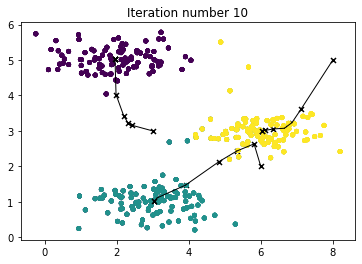

In [21]:
# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx = run_kmeans(X, initial_centroids, max_iters, True)

## Part 4: K-Means Clustering on Pixels

In [22]:
# Load an image of a bird
img = io.imread('/content/drive/MyDrive/Coursera_ML/Exer_7/bird_small.png')
img = img_as_float(img)

In [23]:
# Size of the image
img_shape = img.shape

In [24]:
# Divide by 255 so that all values are in the range 0 - 1
img = img / 255

In [25]:
# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = img.reshape(img_shape[0] * img_shape[1], 3)

In [26]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16
max_iters = 10

In [27]:
# When using K-Means, it is important the initialize the centroids
# randomly.
# You should complete the code in kMeansInitCentroids.py before proceeding
initial_centroids = kmeans_init_centroids(X, K)

In [28]:
# Run K-Means
centroids, idx = run_kmeans(X, initial_centroids, max_iters, False)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


## Part 5: Image Compression

In [29]:
# Find closest cluster members
idx = find_closest_centroids(X, centroids)

In [30]:
# Essentially, now we have represented the image X as in terms of the
# indices in idx.

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
X_recovered = centroids[idx]

In [31]:
# Reshape the recovered image into proper dimensions
X_recovered = X_recovered.reshape((img_shape[0], img_shape[1], 3))

(-0.5, 127.5, 127.5, -0.5)

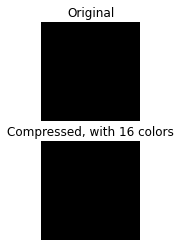

In [32]:
# Display the original image
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Display compressed image side by side
plt.subplot(2, 1, 2)
plt.imshow(X_recovered)
plt.title('Compressed, with {} colors'.format(K))
plt.axis('off')

# PCA

## Part 1: Load Example Dataset

In [33]:
# The following command loads the dataset. You should now have the 
# variable X in your environment
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_7/ex7data1.mat')
X = data['X']

(0.5, 6.5, 2.0, 8.0)

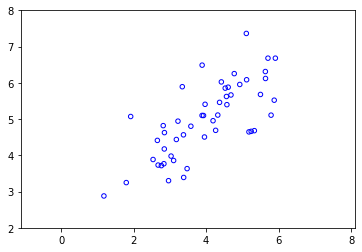

In [34]:
# Visualize the example dataset
plt.scatter(X[:, 0], X[:, 1], s=20, edgecolors='b', facecolors='none')
plt.axis('equal')
plt.axis([0.5, 6.5, 2, 8])

## Part 2: Principal Component Analysis

In [35]:
# Before running PCA, it is important to first normalize X
X_norm, mu, sigma = feature_normalize(X)

In [36]:
# Run PCA
U, S = pca(X_norm)

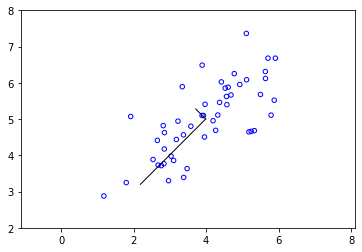

In [37]:
plt.scatter(X[:, 0], X[:, 1], s=20, edgecolors='b', facecolors='none')
plt.axis('equal')
plt.axis([0.5, 6.5, 2, 8])
draw_line(mu, mu + 1.5 * S[0] * U[:, 0])
draw_line(mu, mu + 1.5 * S[1] * U[:, 1])

In [38]:
print('Top eigenvector: \nU[:, 0] = {}'.format(U[:, 0]))
print('You should expect to see [-0.707107 -0.707107]')

Top eigenvector: 
U[:, 0] = [-0.70710678 -0.70710678]
You should expect to see [-0.707107 -0.707107]


## Part 3: Dimension Reduction

(-4.0, 3.0, -4.0, 3.0)

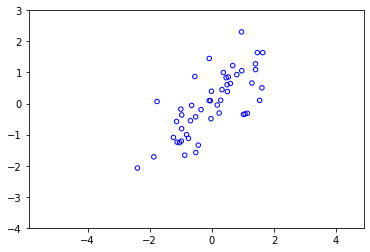

In [39]:
# Plot the normalized dataset (returned from pca)
plt.scatter(X_norm[:, 0], X_norm[:, 1], edgecolors='b', facecolors='none', s=20)
plt.axis('equal')
plt.axis([-4, 3, -4, 3])

In [40]:
# Project the data onto K = 1 dimension
K = 1
Z = project_data(X_norm, U, K)
print('Projection of the first example: {}'.format(Z[0]))
print('(this value should be about 1.481274)')

Projection of the first example: [1.48127391]
(this value should be about 1.481274)


In [41]:
X_rec = recover_data(Z, U, K)
print('Approximation of the first example: {}'.format(X_rec[0]))
print('(this value should be about [-1.047419 -1.047419])')

Approximation of the first example: [-1.04741883 -1.04741883]
(this value should be about [-1.047419 -1.047419])


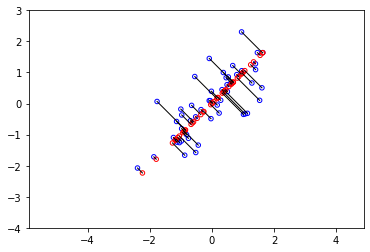

In [42]:
plt.scatter(X_norm[:, 0], X_norm[:, 1], edgecolors='b', facecolors='none', s=20)
plt.axis('equal')
plt.axis([-4, 3, -4, 3])
plt.scatter(X_rec[:, 0], X_rec[:, 1], edgecolors='r', facecolors='none', s=20)
for i in range(X_norm.shape[0]):
    draw_line(X_norm[i], X_rec[i])

## Part 4: Loading and Visualizing Face Data

In [43]:
# Load Face dataset
data = scio.loadmat('/content/drive/MyDrive/Coursera_ML/Exer_7/ex7faces.mat')
X = data['X']

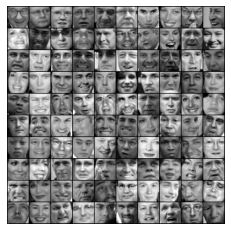

In [44]:
# Display the first 100 faces in the dataset
display_data(X[:100])

## Part 5: PCA on Face Data: Eigenfaces

In [45]:
# Before running PCA, it is important to first normalize X by subtracting
# the mean value from each feature
X_norm, mu, sigma = feature_normalize(X)

In [46]:
# Run PCA
U, S = pca(X_norm)

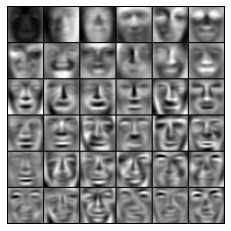

In [47]:
# Visualize the top 36 eigenvectors found
display_data(U[:, :36].T)

## Part 6: Dimension Reduction for Faces

In [48]:
K = 100
Z = project_data(X_norm, U, K)
print('The projected data Z has a shape of: {}'.format(Z.shape))

The projected data Z has a shape of: (5000, 100)


## Part 7: Visualization of Faces after PCA Dimension Reduction

In [49]:
K = 100
X_rec = recover_data(Z, U, K)

(-1.0, 1.0, -1.0, 1.0)

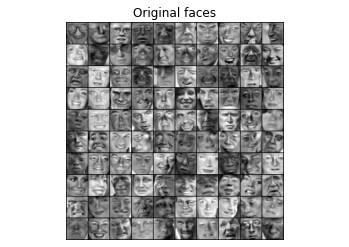

In [50]:
# Display normalized data
display_data(X_norm[:100])
plt.title('Original faces')
plt.axis('equal')

(-1.0, 1.0, -1.0, 1.0)

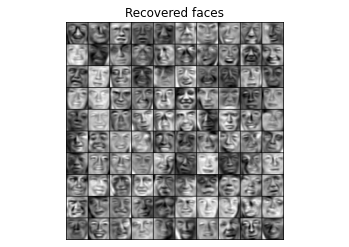

In [51]:
# Display reconstructed data from only k eigenfaces
display_data(X_rec[:100])
plt.title('Recovered faces')
plt.axis('equal')

## Part 8(a): PCA for Visualization

In [52]:
# Reload the image from the previous exercise and run K-Means on it
# For this to work, you need to complete the K-Means assignment first
img = io.imread('/content/drive/MyDrive/Coursera_ML/Exer_7/bird_small.png')
img = img_as_float(img)

In [53]:
img_shape = img.shape

In [54]:
X = img.reshape((img_shape[0] * img_shape[1], 3))
K = 16
max_iters = 10

In [55]:
initial_centroids = kmeans_init_centroids(X, K)
centroids, idx = run_kmeans(X, initial_centroids, max_iters, False)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


In [56]:
# Sample 1000 random indices (since working with all the data is
# too expensive. If you have a fast computer, you may increase this.
selected = np.random.permutation(X.shape[0])[:1000]

Text(0.5, 0.92, 'Pixel dataset plotted in 3D. Color shows centroid memberships')

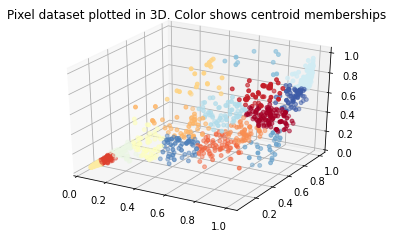

In [57]:
# Visualize the data and centroid memberships in 3D
cm = plt.cm.get_cmap('RdYlBu')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[selected, 0], X[selected, 1], X[selected, 2], c=idx[selected].astype(np.float64), s=15, cmap=cm, vmin=0, vmax=K)
plt.title('Pixel dataset plotted in 3D. Color shows centroid memberships')

## Part 8(b): Optional (ungraded) Exercise: PCA for Visualization

In [58]:
# Subtract the mean to use PCA
X_norm, mu, sigma = feature_normalize(X)

In [59]:
# PCA and project the data to 2D
U, S = pca(X_norm)
Z = project_data(X_norm, U, 2)

Text(0.5, 1.0, 'Pixel dataset plotted in 2D, using PCA for dimensionality reduction')

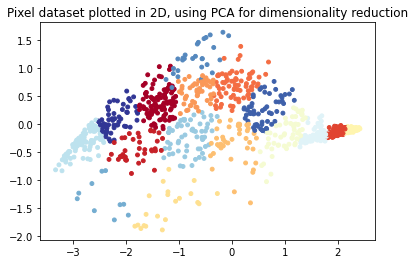

In [60]:
# Plot in 2D
plt.scatter(Z[selected, 0], Z[selected, 1], c=idx[selected].astype(np.float64), s=15, cmap=cm)
plt.title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')